In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import csv
from matplotlib.cbook import boxplot_stats  
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prettytable import PrettyTable
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import ResidualsPlot, PredictionError

## Introduction

Many movies are coming out now that the world is back open from COVID-19. With competition in the movie industry, a model to predict how well a movie will be rated may become necessary in the Hollywood industry. The goal of this project is to determine out of the 3 models, Lasso, Ridge, and RandomForestRegressor, which one is the best model to predict movie ratings, and can we create a highly predictive model from the best selection? 

### Import Dataset

The dataset used in this project was obtained from Kaggle.

https://www.kaggle.com/datasets/carolzhangdc/imdb-5000-movie-dataset

This dataset has 28 features, with 5043 observations. 

* color                        
* director_name                
* num_critic_for_reviews        
* duration                      
* director_facebook_likes      
* actor_3_facebook_likes        
* actor_2_name                  
* actor_1_facebook_likes         
* gross                        
* genres                         
* actor_1_name                  
* movie_title                    
* num_voted_users                
* cast_total_facebook_likes      
* actor_3_name                  
* facenumber_in_poster          
* plot_keywords                
* movie_imdb_link                
* num_user_for_reviews          
* language                      
* country                       
* content_rating               
* budget                       
* title_year                   
* actor_2_facebook_likes        
* imdb_score                    
* aspect_ratio                 
* movie_facebook_likes           

In [359]:
dat = pd.read_csv("movie_metadata.csv", skipinitialspace = True)
dat.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## Data Preprocessing

#### Dropping irrelevant columns

In [360]:
# Dropping columns we will not be using
dat.drop(columns=['title_year','aspect_ratio', 'movie_imdb_link', 'facenumber_in_poster', 'plot_keywords',
                  'actor_2_name', 'actor_1_name', 'actor_3_name', 'director_name'], inplace = True)

We dropped 'title_year','aspect_ratio', 'movie_imdb_link', 'facenumber_in_poster', 'plot_keywords',              'actor_2_name', 'actor_1_name', 'actor_3_name', and 'director_name' from the dataset as the were irrelevant to the model we will be creating. These will be dropped before removing the null values as to minimze the loss of data.

#### Look at the column types and ensure they are correct

In [361]:
# Check the types
dat.dtypes

color                         object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
genres                        object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
actor_2_facebook_likes       float64
imdb_score                   float64
movie_facebook_likes           int64
dtype: object

Types are in the right form, so we do not have to change any types to a different type.

#### Looking at the null values

In [362]:
# Checking for the null values
dat.isnull().sum()

color                         19
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_1_facebook_likes         7
gross                        884
genres                         0
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
actor_2_facebook_likes        13
imdb_score                     0
movie_facebook_likes           0
dtype: int64

We see that gross has almost 884 missing rows, so this column will be dropped. We will also be removing the rows with null values. 

In [363]:
dat.dropna(inplace=True)
dat.drop(columns = ['gross'],inplace=True)
dat.reset_index(inplace=True)

## Data Exploration and more Preprocessing

In this section we will explore the continuous and catagorial variables. We also be continuing with preprocessing the data through Scaling, Dummy Variables, and CountVectorizer.

### Observing the continuous variables

#### Description of continuous variables

In [364]:
dat.describe()

,index,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,actor_2_facebook_likes,imdb_score,movie_facebook_likes
count,3829.000000,3829.000000,3829.000000,3829.000000,3829.000000,3829.00000,3.829000e+03,3829.000000,3829.000000,3.829000e+03,3829.000000,3829.000000,3829.000000
mean,2172.433795,165.163489,110.029773,792.699138,761.915905,7664.52912,1.040751e+05,11396.538522,331.577958,4.554785e+07,1994.395142,6.459258,9267.094803
std,1362.746947,123.897390,22.589822,3040.606690,1877.711663,15442.73807,1.514475e+05,19016.434406,409.669361,2.239303e+08,4511.324225,1.057632,21444.676112
min,0.000000,1.000000,37.000000,0.000000,0.000000,0.00000,2.200000e+01,0.000000,1.000000,2.180000e+02,0.000000,1.600000,0.000000
25%,1006.000000,75.000000,95.000000,10.000000,188.000000,738.00000,1.831000e+04,1882.000000,105.000000,1.000000e+07,374.000000,5.900000,0.000000
50%,2066.000000,136.000000,106.000000,60.000000,433.000000,1000.00000,5.246700e+04,3963.000000,206.000000,2.500000e+07,678.000000,6.600000,225.000000
75%,3210.000000,223.000000,120.000000,232.000000,690.000000,12000.00000,1.263070e+05,16125.000000,394.000000,5.000000e+07,975.000000,7.200000,11000.000000
max,5042.000000,813.000000,330.000000,23000.000000,23000.000000,640000.00000,1.689764e+06,656730.000000,5060.000000,1.221550e+10,137000.000000,9.300000,349000.000000


Looking at our description of the dataset we can see that on average a duration of the movies rated were around 109.3 minutes. We can see that our average score is 6.43044, this is shown more in the distribution of the IMDB score below, were we see around 6.5 containing the most movies with this rating. When looking at actors, the first actor has the highest average number of likes. 

### Visualizations of continuous variables 

#### Distribution of IMDB Score

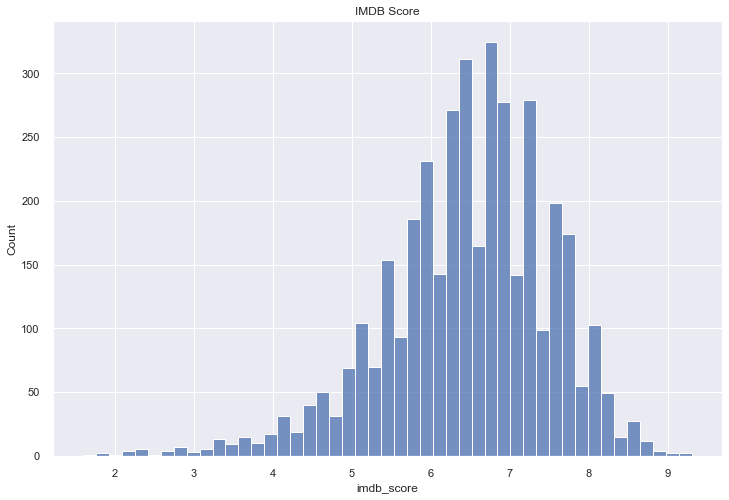

In [365]:
RC = sns.histplot(dat, x = "imdb_score", stat = 'count',
             multiple = 'dodge', palette = "blend:#7AB,#EDA").set(title='IMDB Score')


We see that the distribution of the imdb_score tends to range from 5.5-7.5. The highest number of ratings is around 6.5, which would deem an average movie.

#### Scatterplot Movie FB likes to Rating

[Text(0.5, 1.0, 'Movie FB Likes to Rating')]

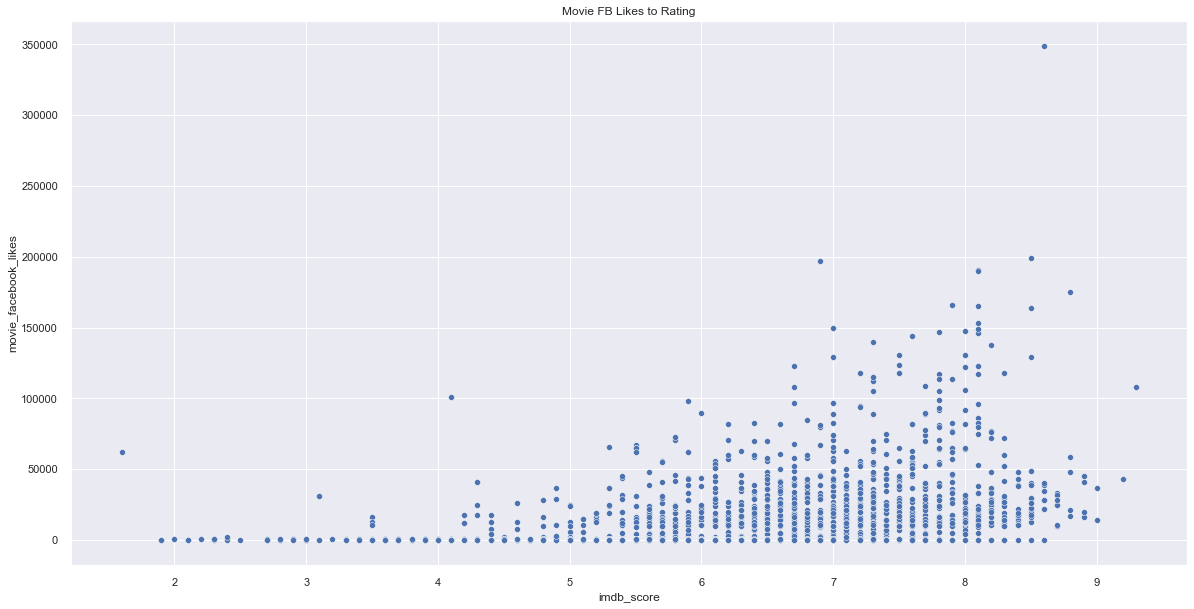

In [366]:
plt.figure(figsize=(20,10))
sns.set_color_codes("pastel")
sns.scatterplot(data = dat, x="imdb_score", y="movie_facebook_likes").set(title='Movie FB Likes to Rating')

Here we can still that majority of the data tends to range in the 5-8 score and as the movie rating increase the number of facebook likes the movie recieves also increases as well. This would make sense as blockbuster movies tend to have more likes on facebook.

#### Scatterplot Duration to Rating

[Text(0.5, 1.0, 'Duration to Rating')]

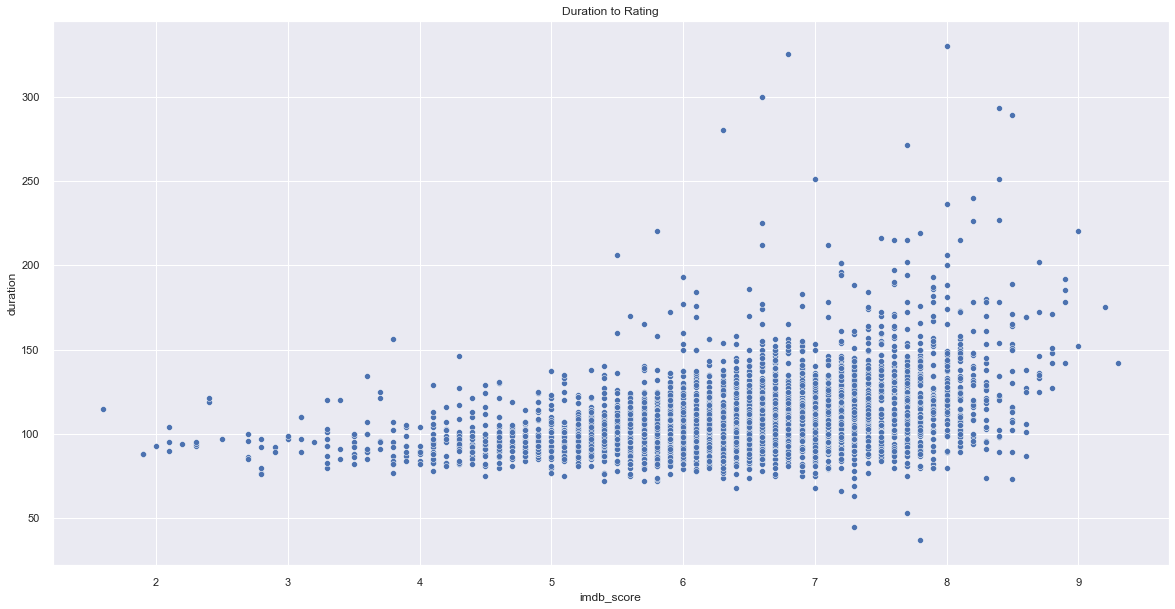

In [367]:
plt.figure(figsize=(20,10))
sns.set_color_codes("pastel")
sns.scatterplot(data = dat, x="imdb_score", y="duration").set(title='Duration to Rating')

Many of the movies tend to range from 90-150 mins, however as we increase in the rating we do see more data points with a longer movie duration.

#### 3-D plot for respondents with duration, num_user_for_reviews, and imdb score

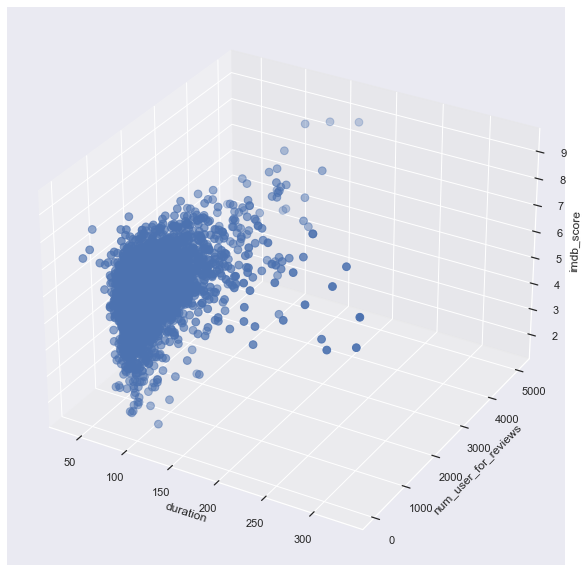

In [368]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dat['duration'], dat['num_user_for_reviews'], dat['imdb_score'], s=60)
ax.set_xlabel('duration')
ax.set_ylabel('num_user_for_reviews')
ax.set_zlabel('imdb_score')
plt.show()

When comparing the number of users for reviews to duration to the IMDB score, we see that while the duration tends to range from 50-150, as the number of user for reviews increases, so does the score. 

#### Scaling the continuous variables

In [369]:
scaler = StandardScaler()
scaler.fit(dat[['num_critic_for_reviews','duration', 'director_facebook_likes', 'actor_3_facebook_likes', 
                'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 
                'num_user_for_reviews', 'budget','actor_2_facebook_likes','movie_facebook_likes']])
scale_Dat = scaler.transform(dat[['num_critic_for_reviews','duration', 'director_facebook_likes', 'actor_3_facebook_likes', 
                'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 
                'num_user_for_reviews', 'budget','actor_2_facebook_likes','movie_facebook_likes']])
scaled_Dat = pd.DataFrame(scale_Dat, columns = ['num_critic_for_reviews','duration', 'director_facebook_likes', 'actor_3_facebook_likes', 
                'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 
                'num_user_for_reviews', 'budget','actor_2_facebook_likes','movie_facebook_likes'])

In [370]:
scaled_Dat

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,actor_2_facebook_likes,movie_facebook_likes
0,4.502995,3.009280,-0.260738,0.049580,-0.431620,5.165033,-0.345143,6.646281,0.855075,-0.234639,1.106848
1,1.104578,2.610819,-0.075554,0.126811,2.094168,2.424556,1.943492,2.212859,1.136449,0.666323,-0.432196
2,3.526253,1.681075,-0.260738,-0.320067,0.216018,1.134488,0.015960,1.617179,0.890805,-0.355019,3.532009
3,5.229498,2.389451,6.975605,11.844730,1.252239,6.869694,5.015394,5.784498,0.913136,4.656803,7.216389
4,2.396138,0.972699,-0.104499,-0.123526,-0.454935,0.714063,-0.500871,0.992203,0.974324,-0.302034,0.687109
...,...,...,...,...,...,...,...,...,...,...,...
3824,-0.178909,-1.462344,-0.165021,-0.401560,-0.477538,-0.207598,-0.580024,0.096241,-0.203397,-0.432168,0.453920
3825,-1.050712,-1.329523,-0.260738,-0.405821,-0.496384,-0.683402,-0.599378,-0.724039,-0.203397,-0.442144,-0.428745
3826,-0.881195,-1.285250,-0.260738,-0.402626,-0.488548,-0.343531,-0.591647,-0.492115,-0.203397,-0.437710,-0.432196
3827,-1.220229,-0.665421,-0.260738,-0.334981,-0.477214,-0.678456,-0.563089,-0.775307,-0.203388,-0.396697,-0.412935


In [371]:
for col in scaled_Dat.columns:
    dat[col]=scaled_Dat[col]

#### Pairplot for Continuous Variables
We looked at these specicfic continous variable columns for the pairplot: 'num_critic_for_reviews','duration', 'director_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget','movie_facebook_likes', 'imdb_score'.

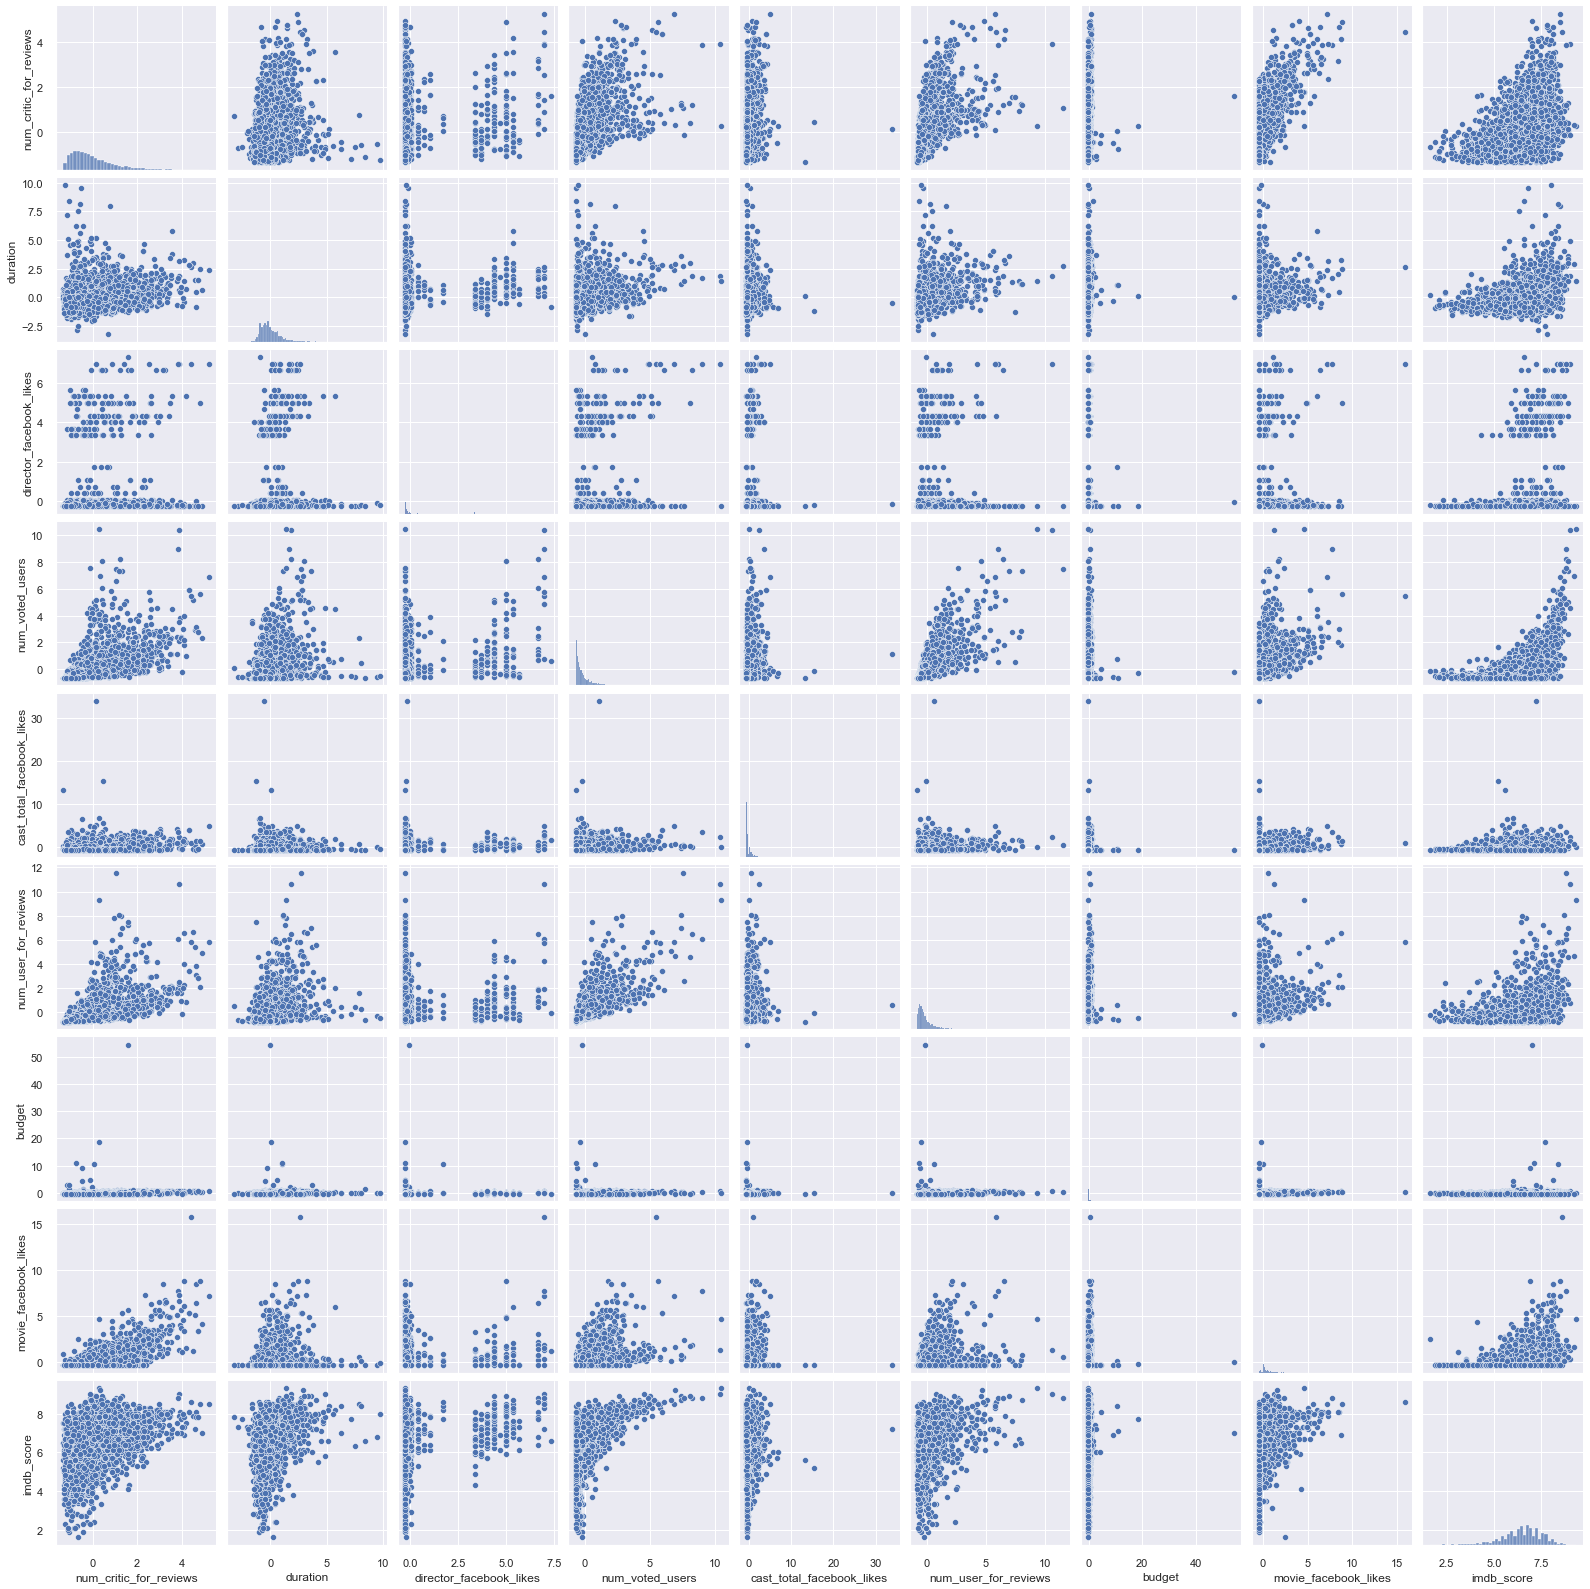

In [372]:
temp = dat[['num_critic_for_reviews','duration', 'director_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes', 
                'num_user_for_reviews', 'budget','movie_facebook_likes', 'imdb_score']]
sns.pairplot(data = temp)
plt.show()

In the pairplot we see many continuous variables such as the budget, number of user ratings, and number of critics reviews that the distribution when compared with the IMDB score shows that the data is left-skewed. The comparison of cast total Facebook likes to all other variables shows so outliers that appear very large. Same for budget, we see a large data point at 50 indicating it is an outlier.  

#### Correlation between the target and the selected continuous variables

                           num_critic_for_reviews  duration  \
num_critic_for_reviews                   1.000000  0.238177   
duration                                 0.238177  1.000000   
director_facebook_likes                  0.177163  0.181793   
num_voted_users                          0.597635  0.345324   
cast_total_facebook_likes                0.239671  0.123015   
num_user_for_reviews                     0.569828  0.356867   
budget                                   0.107312  0.070016   
movie_facebook_likes                     0.704289  0.221870   
imdb_score                               0.348335  0.366519   

                           director_facebook_likes  num_voted_users  \
num_critic_for_reviews                    0.177163         0.597635   
duration                                  0.181793         0.345324   
director_facebook_likes                   1.000000         0.300580   
num_voted_users                           0.300580         1.000000   
cast_total_fac

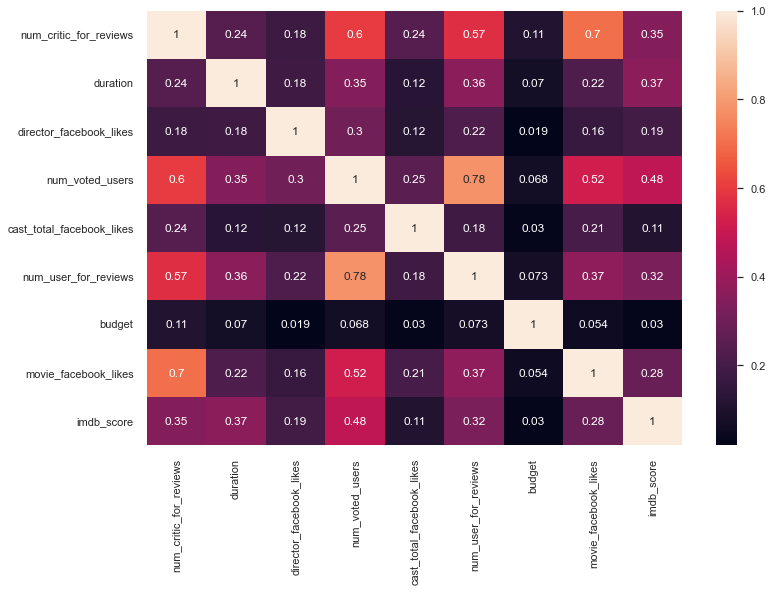

In [373]:
corrMatrix = temp.corr()
print (corrMatrix)
sns.set(rc={"figure.figsize":(12, 8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

From the correlation matrix we see that the number of voted users has the strongest postitive correlation to the IMDB_Score with 0.48, then duration with 0.37, then num_critic_for_reviews with 0.35, and last num_user_for_reviews with 0.32. Budget had almost no correlation with the imdb_score. It obtained a score of 0.03. 

#### Removing outliers from the 4 variables with strongest positive correlation, as well as budget. 
Budget was included becuase this had such a widespread of data, and the very large data point at 50. 

In [374]:
nstd = 3.0
for col in ['num_voted_users', 'num_critic_for_reviews', 'duration', 'num_user_for_reviews', 'budget']:
    data_mean, data_std = dat[col].mean(), dat[col].std()
    dist = data_std * nstd
    lower_bound, upper_bound = data_mean - dist, data_mean + dist
    outliers_mask = [True if x < lower_bound or x > upper_bound else False for x in dat[col]]
    outliers = dat[col][outliers_mask].index.tolist()
    for i in outliers:
        dat.drop(axis=0, index=i, inplace = True)

In [375]:
dat.reset_index(inplace=True)

#### Boxplot of Duration

[Text(0.5, 1.0, 'Boxplot of Duration')]

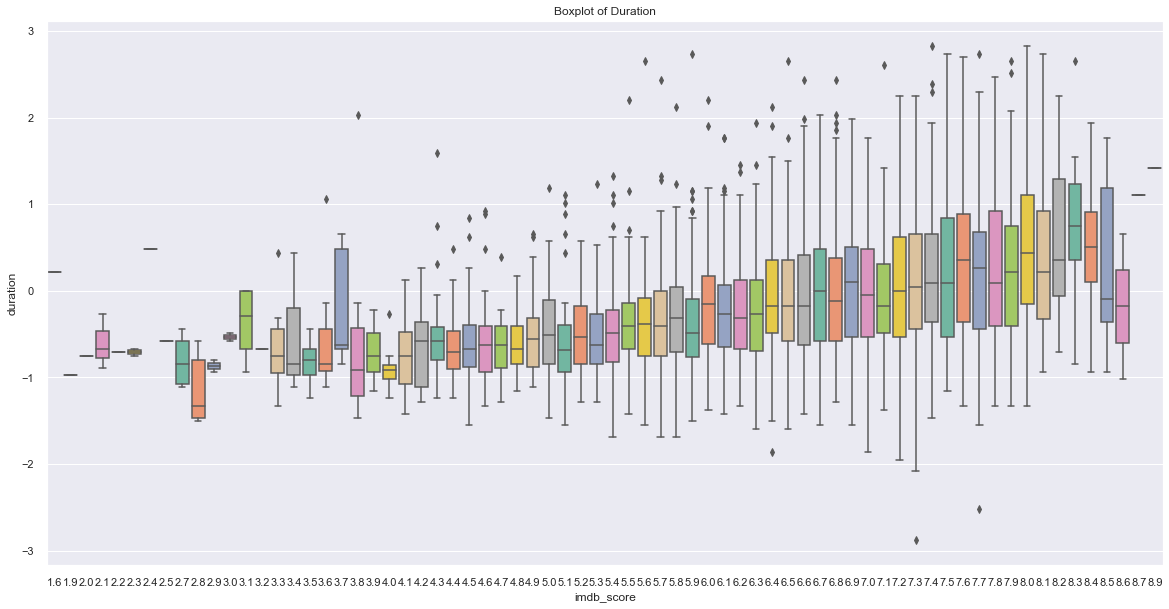

In [377]:
plt.figure(figsize=(20,10))
sns.boxplot(data = dat, x="imdb_score", y="duration", palette = 'Set2').set(title="Boxplot of Duration")

#### Boxplot Number of Voted Users to Rating

[Text(0.5, 1.0, 'Boxplot of Number of Voted Users')]

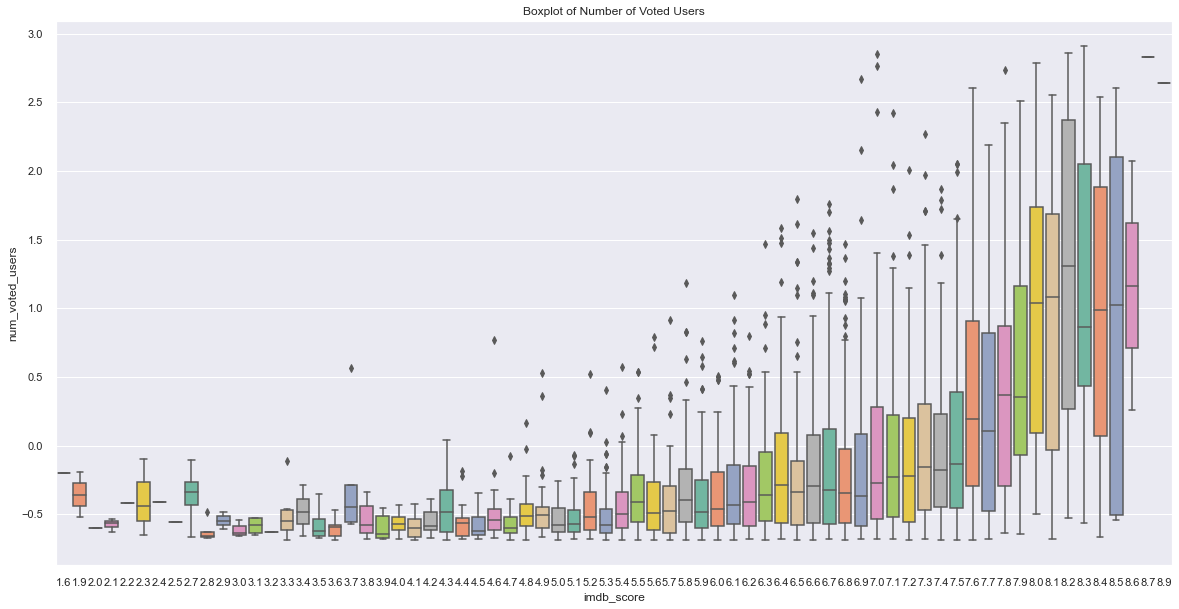

In [378]:
plt.figure(figsize=(20,10))
sns.boxplot(data = dat, x="imdb_score", y="num_voted_users", palette = 'Set2').set(title="Boxplot of Number of Voted Users")

#### Boxplot Number of Critic Users to Rating

[Text(0.5, 1.0, 'Boxplot of Number of Voted Users')]

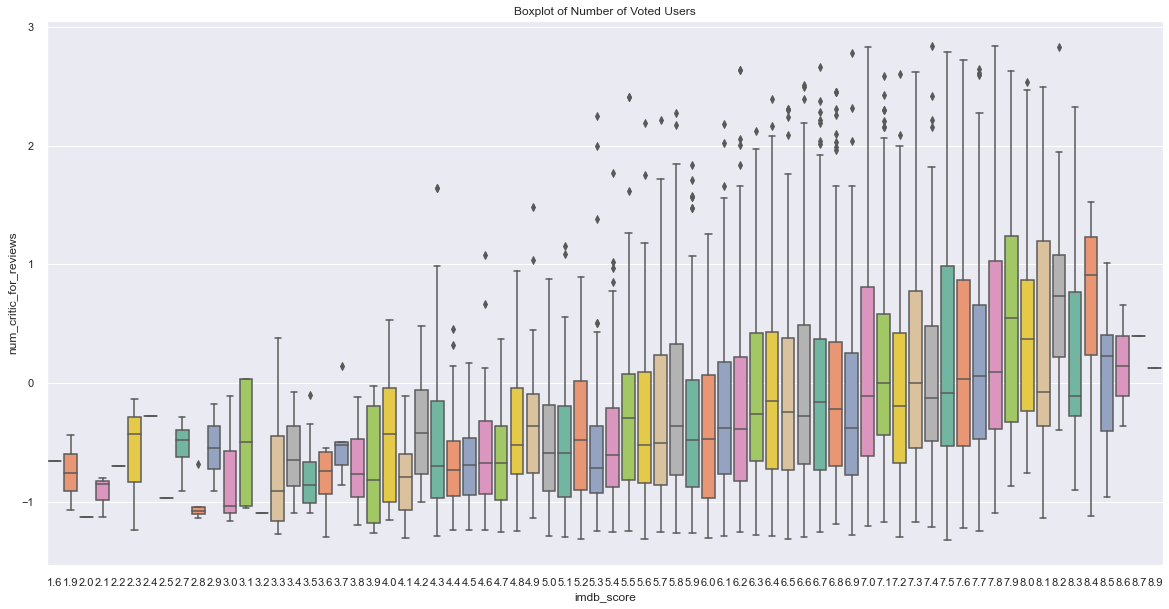

In [379]:
plt.figure(figsize=(20,10))
sns.boxplot(data = dat, x="imdb_score", y="num_critic_for_reviews", palette = 'Set2').set(title="Boxplot of Number of Voted Users")

#### Boxplot Number of Users for Reviews to Rating

[Text(0.5, 1.0, 'Boxplot of Number of Voted Users')]

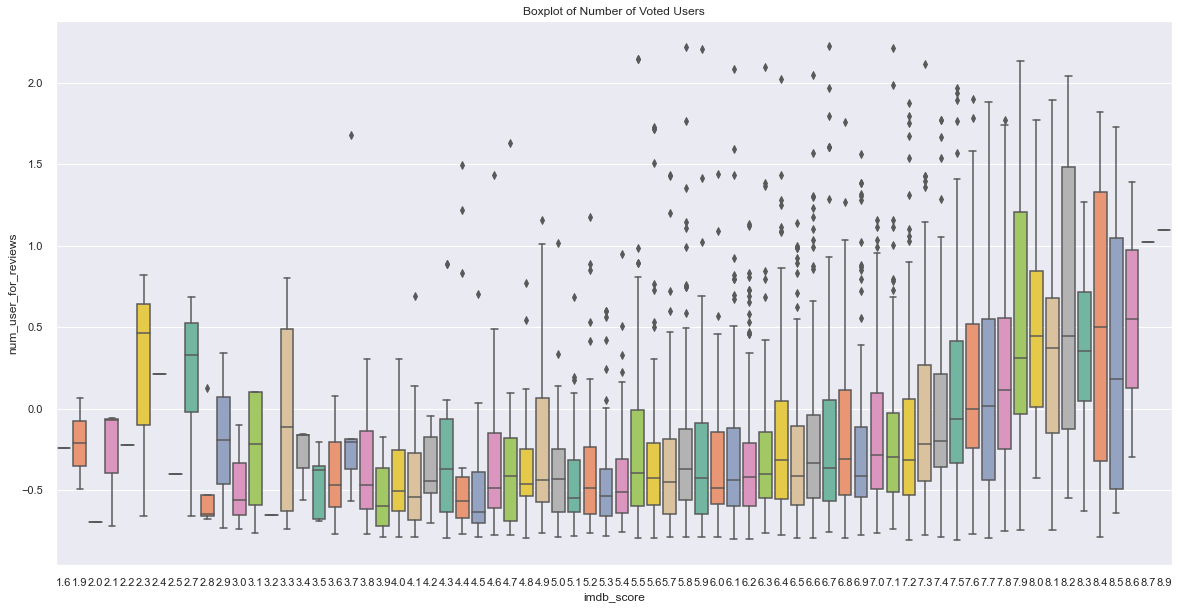

In [380]:
plt.figure(figsize=(20,10))
sns.boxplot(data = dat, x="imdb_score", y="num_user_for_reviews", palette = 'Set2').set(
    title="Boxplot of Number of Voted Users")

### Observing the catagorical variables

#### Ratings by Color of Movie

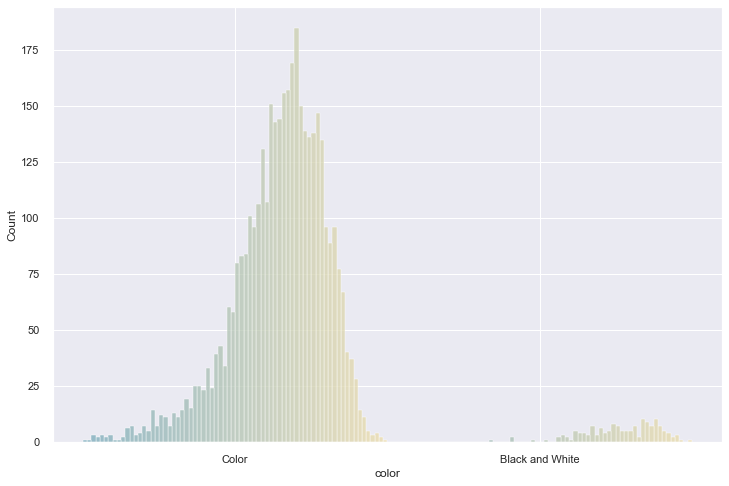

In [162]:
RC = sns.histplot(dat, x = "color", hue = "imdb_score", bins = 10, stat = 'count',
             multiple = 'dodge', palette = "blend:#7AB,#EDA")
RC.legend_.remove()

In this plot we have the frequency going from darker (lower rating) to lighter (higher rating). We do see that there are more color movies than black and white in the dataset, and that color tends to have majority of its ratings fall between 6.0-7.5, while black and white has a spread of ratings. 

#### Average rating by color of movie

<AxesSubplot:xlabel='color', ylabel='imdb_score'>

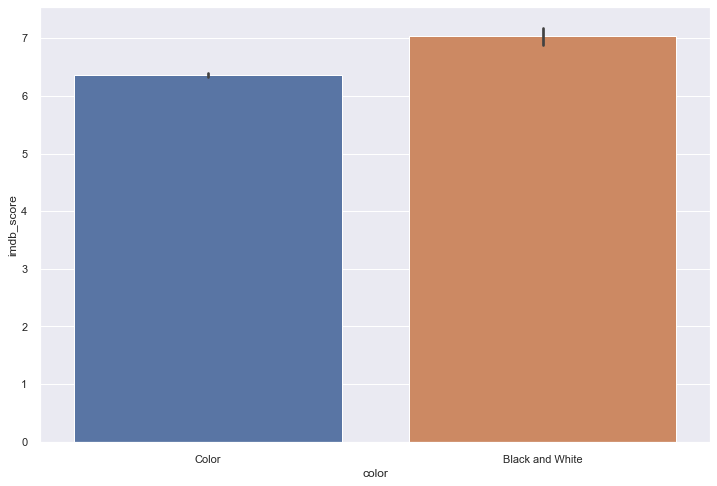

In [381]:
sns.set_color_codes("pastel")
sns.barplot(data = dat, x="color", y="imdb_score")

In [382]:
dat.groupby(['color'])['imdb_score'].mean()

color
Black and White    7.037736
Color              6.357217
Name: imdb_score, dtype: float64

Here we see that color movies on average recive a lesser rating than black and white. It is important to take into account that color has a larger number of observations than black and white. However, when looking at the average rating black and white has a higher movie rating than a color movie.

### Rating vs Content Rating

[Text(0.5, 1.0, 'IMDB Score vs Content Rating')]

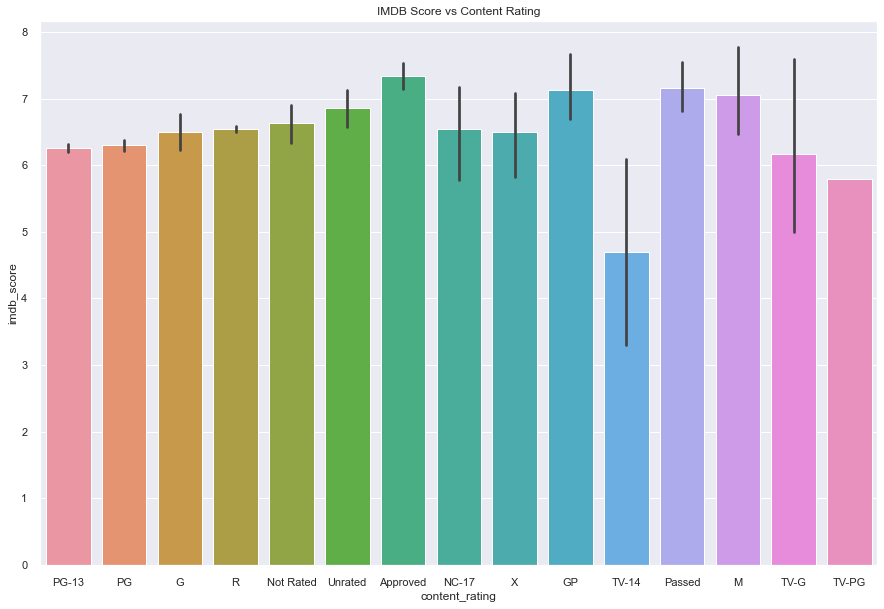

In [312]:
plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(data = dat, x="content_rating", y="imdb_score").set(title="IMDB Score vs Content Rating")

Meaning of movie ratings per IMDB:

* PG-13: Parental guidence for 13 & over, 
* PG: Parental guidence suggested
* G: General Audiences
* R: Restricted for children under 17, require a parent
* Approved: Suitable for under 7 years old
* Passed: Only for persons 12 and older
* NC-17:No children 17 and under
* TV-14: 14 over
* TV-G: General Audience
* TV-PG: Parental Guidence
* X: suitable only for adults
* Not Rated: film was not submitted for a rating
* Unrated: not given rating, usually worse than R
* M: mature audience
* GP: Parental guidence suggested, can be deemed the same as PG

#### Looking the total per rating, then grouping by similar movie rating

In [165]:
dat['content_rating'].value_counts()

R            1813
PG-13        1251
PG            624
G              92
Not Rated      80
Unrated        48
Approved       48
X              12
Passed          9
NC-17           7
GP              4
M               4
TV-G            3
TV-14           2
TV-PG           1
Name: content_rating, dtype: int64

We are going to bin the ratings into only 4 ratings, G, PG, PG-13, R and above. The G rating will include G & Approved, PG will include PG & GP, PG-13 will include PG-13 and Passed, R+ will include the rest as they are for 17 and over.


In [166]:
d = {"G":"G", "Approved":"G", "PG":"PG", "GP":"PG", "PG-13":"PG-13", "Passed":"PG-13", "R":"R+",
    "Not Rated":"R+", "Unrated":"R+", "X":"R+", "NC-17":"R+", "M":"R+", "TV-14":"PG-13", "TV-G": "G", "TV-PG": "PG"}
dat["content_ratings"] = dat["content_rating"].map(d)

In [167]:
dat.drop(columns=['level_0', 'index'], inplace=True)

#### Average rating by content rating of movie

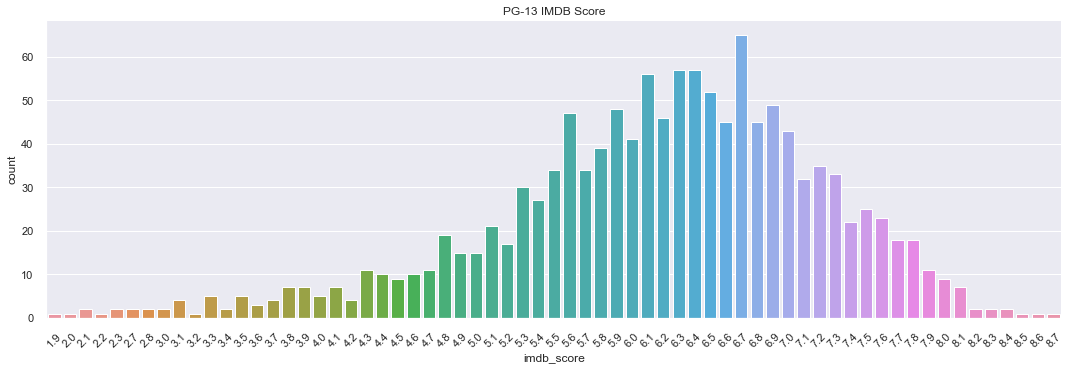

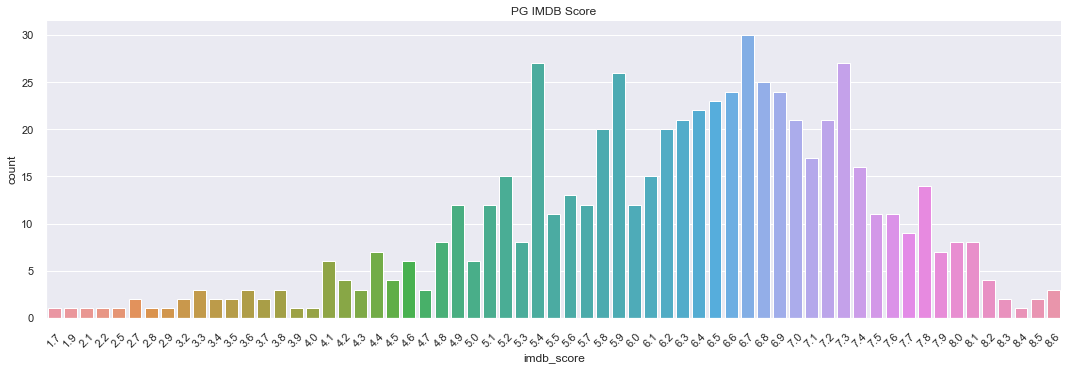

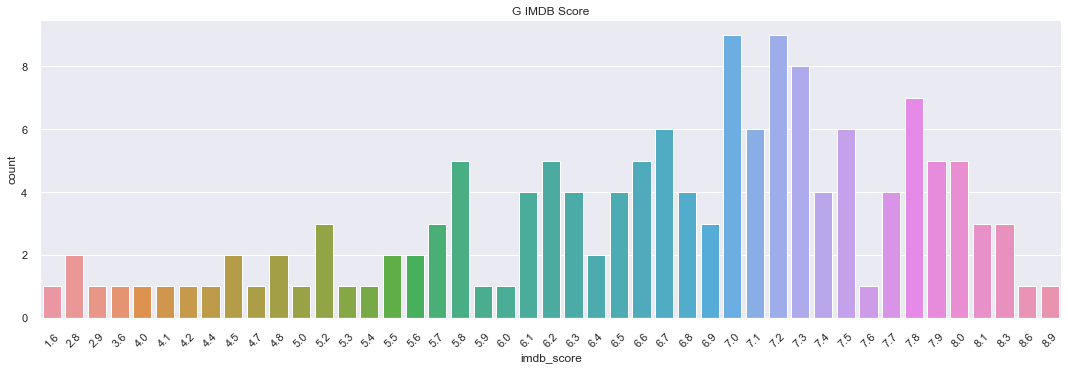

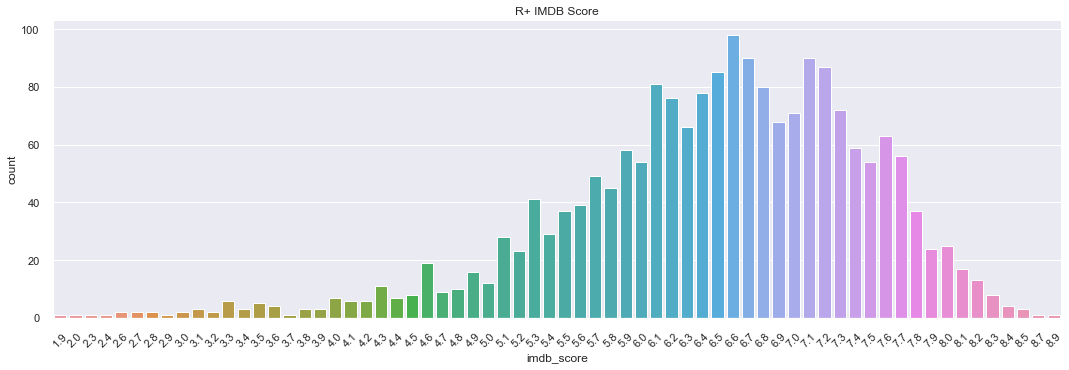

In [168]:
ratings = dat['content_ratings'].unique()
for rating in ratings:
    sns.set_color_codes("pastel")
    sns.catplot(data=dat[dat['content_ratings'] == rating], x="imdb_score", 
                kind = 'count', height=5, aspect=3)
    plt.title(f"{rating} IMDB Score")
    plt.xticks(rotation=45)

## Final Data Preprocessing

### Create dummy variables for ratings

In [169]:
rDums = pd.get_dummies(dat.content_ratings)
rDums = rDums.astype('float')

### Creating Dummy Variables for Language and Country Columns

We will be creating dummy variables for the language and country columns to use in the model to predict the IMDB score. 

In [170]:
langs = pd.get_dummies(dat.language)
langs =langs.astype('float')
countries = pd.get_dummies(dat.country)
countries = countries.astype('float')

### Transforming Color column to 0 and 1
Since this column only has two variables we will be mapping the categories to 0 and 1 with 0 representing Black and White, and 1 representing Color.

In [171]:
d = {"Color":1, "Black and White":0}
dat["movie_color"] = dat["color"].map(d)

### Transforming text data into numeric data 

In [172]:
# count vectorization of text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [173]:
# Getting the text data 
titles = pd.DataFrame(dat['movie_title'])

In [174]:
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
txt = vectorizer.fit_transform(titles['movie_title'].values)

In [175]:
vectText=pd.DataFrame(txt.toarray(), columns=vectorizer.get_feature_names())
vectText['originalTitle']=pd.Series(titles['movie_title'].values)
vectText

C:\Users\15599\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,10,1000,102,10th,11,12,127,13,13th,...,zombieland,zombies,zone,zookeeper,zoolander,zoom,zorro,zulu,æon,originalTitle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,John Carter
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tangled
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Harry Potter and the Half-Blood Prince
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The Lone Ranger
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The Chronicles of Narnia: Prince Caspian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Primer
3994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cavite
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,El Mariachi
3996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Newlyweds


### Gathering the Genre

In the column 'genre', there are multiple different genres that are separated by a '|'. In order to created dummy variables for this column, it was necessary to split the value, then create the dummy variable. 

In [176]:
def extract(x, g_list):
    """Function to create the list of genres"""
    for g in x:
        g_list.append(g)
    return g_list

In [177]:
temp2 = dat.astype({'genres':str})
complete_list = []
for i in range(len(temp2)):
    stats = temp2['genres'].iloc[i]
    ch = '|'
    if ch in stats:
        text_list = stats.split("|")
    else:
        text_list = []
        text_list.append(stats)
    complete_list = extract(text_list, complete_list)
genres = np.unique(complete_list)

In [178]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='<U11')

In [179]:
genDF = pd.DataFrame(columns=['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'])

In [180]:
for i in range(len(temp2)):
    stats = temp2['genres'].iloc[i]
    ch = '|'
    if ch in stats:
        text_list = stats.split("|")
    else:
        text_list = []
        text_list.append(stats)
    genDF.loc[i] = [x in text_list for x in genres]
    genDF.replace({False: 0, True: 1}, inplace=True)

In [181]:
genDF.head(5)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,1,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Concat all transformed variables to form final Data Frame

genDF
vectText
movie_dat
rDums
langs
countries

In [182]:
movieFinal = pd.concat([dat.reset_index(drop=True), genDF.reset_index(drop=True), langs.reset_index(drop=True), countries.reset_index(drop=True), vectText.reset_index(drop=True), rDums.reset_index(drop=True)], axis = 1)

In [183]:
movieFinal.drop(columns=['color', 'movie_title', 'originalTitle', 'genres', 
                         'content_rating', 'language', 'country', 'content_ratings'], inplace =True)

In [184]:
movieFinal

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,actor_2_facebook_likes,...,zookeeper,zoolander,zoom,zorro,zulu,æon,G,PG,PG-13,R+
0,2.508757,1.004482,-0.096913,-0.100044,-0.435260,0.798128,-0.475888,1.086961,1.050553,-0.280354,...,0,0,0,0,0,0,0.0,0.0,1.0,0.0
1,1.385557,-0.412196,-0.251896,-0.238268,-0.424631,1.362998,-0.467019,0.200685,1.033065,-0.298741,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
2,1.800652,1.934177,-0.161939,5.221025,1.193135,1.547525,2.619055,1.680337,0.985800,2.132710,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
3,2.411087,1.801363,-0.067264,0.164043,2.195841,0.590166,1.911919,1.018786,0.820371,0.038036,...,0,0,0,0,0,0,0.0,0.0,1.0,0.0
4,0.848374,1.801363,-0.229996,-0.284905,0.992594,0.372235,0.657183,0.329460,0.867636,-0.377175,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,-0.087626,-1.430434,-0.158906,-0.393349,-0.458590,-0.156236,-0.557778,0.160285,-0.195799,-0.416973,...,0,0,0,0,0,0,0.0,0.0,1.0,0.0
3994,-0.966652,-1.297620,-0.256950,-0.397844,-0.478042,-0.648924,-0.577802,-0.688116,-0.195799,-0.427447,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
3995,-0.795730,-1.253349,-0.256950,-0.394473,-0.469954,-0.296992,-0.569803,-0.448240,-0.195799,-0.422792,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
3996,-1.137573,-0.633552,-0.256950,-0.323113,-0.458256,-0.643802,-0.540258,-0.741141,-0.195789,-0.379735,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0


## Data Model
Building the model. We will be testing 3 models, RandomForestRegressor, Lasso, and Rdige. Our target variable will be imdb_score. Focusing on R2 and MSE score to determine which model is best. 

#### Splitting the dataset into train, test sets. I will be utiliizing a 80/20 split

In [314]:
# Train Test Split with 20%
y = movieFinal['imdb_score']
X = movieFinal.drop('imdb_score', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Running the models, utilizing the RSME.

In [188]:
models = [Lasso(), Ridge(), RandomForestRegressor()]

In [189]:
# Creating Pretty Table
tbl = PrettyTable()
tbl.field_names = ["Model name", "Train MSE", "Test MSE"]

In [190]:
for model in models:
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train) 
    tstf1 = mean_squared_error(y_test, test_preds)
    trnf1 = mean_squared_error(y_train, train_preds)
    tbl.add_row([model, trnf1, tstf1])

In [191]:
print(tbl)

+-------------------------+---------------------+--------------------+
|        Model name       |      Train MSE      |      Test MSE      |
+-------------------------+---------------------+--------------------+
|         Lasso()         |  1.1747146815493268 | 1.0385000620404168 |
|         Ridge()         | 0.17379096867369118 | 0.5631050160307122 |
| RandomForestRegressor() | 0.07308763508442778 | 0.4438233312499999 |
+-------------------------+---------------------+--------------------+


From the scores, Lasso did the worst with a MSE of 1.039, then Ridge with 0.563, and lastly RandomForestRegressor with 0.44. However it was noticed that the train data set was overfitting the data as it had significantly better scores than the test sets for Ridge and RandomForestRegressor. 

### Data Hyperparameter tuning

#### Lasso Hyperparameter Tuning

In [192]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [193]:
new_params = {'alpha': np.linspace(0.1, 1.0, 21)}
grid_ls_new = GridSearchCV(estimator = Lasso(), param_grid = new_params, scoring="r2")
grid_ls_new.fit(X_train, y_train)
print(grid_ls_new.best_estimator_)

Lasso(alpha=0.1)


We found that alpha set to 0.1 is the best parameter. 

#### Ridge Hyperparameter Tuning

In [194]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [195]:
new_params = {'alpha': np.linspace(0.1, 1.0, 21)}
grid_rg_new = GridSearchCV(estimator = Ridge(), param_grid = new_params, scoring="r2")
grid_rg_new.fit(X_train, y_train)
print(grid_rg_new.best_estimator_)

Ridge()


Found that the alpha set to 1.0 is the best parameter to use. 

#### RandomForestRegressor Hyperparameter Tuning

In [197]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [198]:
new_params = [{'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 
               'max_depth': [None, 5, 10], 'bootstrap': [True, False]}]

In [199]:
grid_rfr_new = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), param_grid = new_params, scoring="r2")
grid_rfr_new.fit(X_train, y_train)
print(grid_rfr_new.best_estimator_)

RandomForestRegressor(n_estimators=200, random_state=42)


We found that the best parameters for RandomForestRegressor are (n_estimators=200, random_state=42)

### New Model Performance

Utilizing our new found best parameters for our models, we will re-test our models and select out the best model.

In [200]:
models = [grid_ls_new.best_estimator_, grid_rg_new.best_estimator_, grid_rfr_new.best_estimator_]

In [201]:
# Creating Pretty Table
tbl = PrettyTable()
tbl.field_names = ["Model name", "R2", "MSE"]

In [202]:
for model in models:
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test) 
    tstmse = mean_squared_error(y_test, test_preds, squared = True)
    r2 = r2_score(y_test, test_preds)
    tbl.add_row([model, r2, tstmse])

In [203]:
print(tbl)

+----------------------------------------------------------+---------------------+---------------------+
|                        Model name                        |          R2         |         MSE         |
+----------------------------------------------------------+---------------------+---------------------+
|                     Lasso(alpha=0.1)                     |  0.2690730616599587 |  0.753962272112829  |
|                         Ridge()                          | 0.45409917637144726 |  0.5631050160307122 |
| RandomForestRegressor(n_estimators=200, random_state=42) |  0.5769753897387755 | 0.43635632999999996 |
+----------------------------------------------------------+---------------------+---------------------+


From the table we can see that the best model selection is RandomForestRegressor as it has the highest R2 and the lowest MSE. We will further analyze with more hypertuning. 

## Further Best Model Hypertuning and Performance on best model

Utilizing our new found best model, we will hypertune the model more. 

In [204]:
new_params = [{'n_estimators': [150, 200, 250], 'max_features': ['auto', 'sqrt'], 
               'max_depth': [None, 15, 20], 'bootstrap': [True, False]}]

In [205]:
grid_rfr_new = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid = new_params, scoring="r2")
grid_rfr_new.fit(X_train, y_train)
print(grid_rfr_new.best_estimator_)

RandomForestRegressor(n_estimators=200, random_state=42)


Even when expanding on max_features and estimators, we still find that the best parameters for the model are:

RandomForestRegressor(n_estimators=200, random_state=42)

In [316]:
print(grid_rfr_new.best_estimator_)
model = grid_rfr_new.best_estimator_
model.fit(X_train, y_train)
test_preds = model.predict(X_test) 
tstmse = mean_squared_error(y_test, test_preds, squared = True)
tstabs = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print(f"MSE: {tstmse}")
print(f"Overall Mean Absolute Error: {tstabs}")
print(f"Overall R2: {r2}")

RandomForestRegressor(n_estimators=200, random_state=42)
MSE: 0.43635632999999996
Overall Mean Absolute Error: 0.4708562499999999
Overall R2: 0.5769753897387755


## Predicted vs Actual and Residuals Plot

C:\Users\15599\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


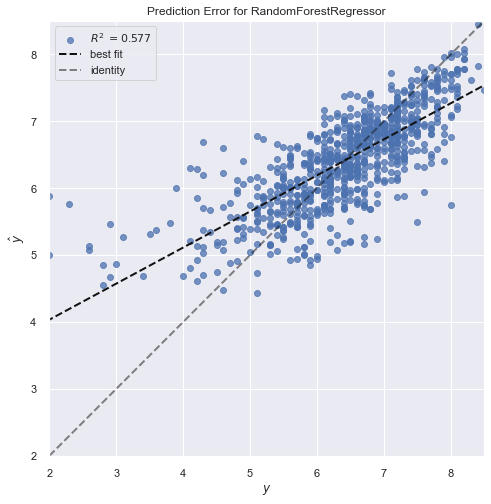

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [383]:
predact = PredictionError(model)
predact.fit(X_train, y_train)  
predact.score(X_test, y_test)  
predact.show()

 In the Predicted vs Actual plot for the test predictions, we see that the the higher the rating the better the model performed, however when it came to a low rating it was not good at predicting. It does not appear to follow the identity line.

### Residuals Plot

C:\Users\15599\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


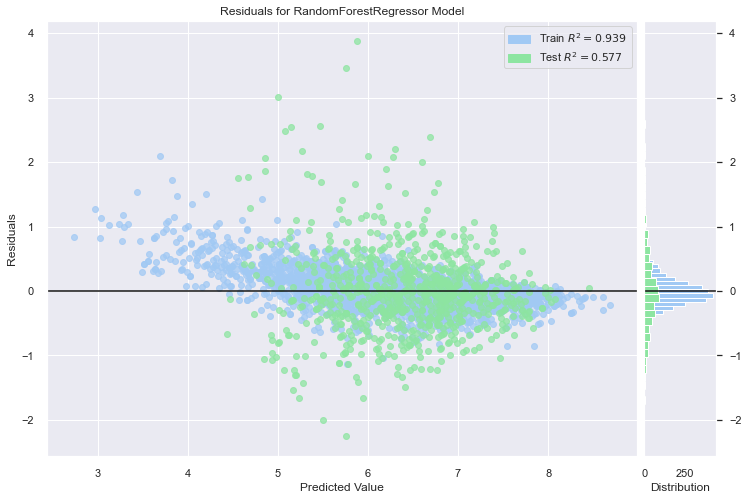

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [385]:
resplt = ResidualsPlot(model)
resplt.fit(X_train, y_train)
resplt.score(X_test, y_test)
resplt.show()

 In the Residuals plot, the test set residuals did have some in the -1 to 1 range, however there were points that were far away from the 0 line. The train set residuals did far better with majority of the distribution between the -1 to 1 range. This is an indication that there is still overfitting in the model. 